# Exercise 09.1

The traveling salesman problem (TSP) consists of a salesman and a set of $N$ cities with positions $\vec{c}_i$. The salesman has to visit each one of the cities starting from a certain one (e.g. the hometown) and returning to the same city. The challenge of the problem is that the traveling salesman wants to minimize the total length of the trip.


Consider now the ordered sequence of cities, $\vec{c}_1, \vec{c}_2, \dots, \vec{c}_N$, which goes from city 1 to the n$^{th}$ city. The path that minimizes the following loss/cost function:

$$
L^{(2)}(\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N) = \sum_{i=1}^{N} |\vec{x}_i-\vec{x}_{i+1}|^2
$$

or 
$$
L^{(1)}(\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N) = \sum_{i=1}^{N} |\vec{x}_i-\vec{x}_{i+1}|
$$


(with $\vec{x}_{N+1}=\vec{x}_1$) is one particular permutation, P, of the ordered sequence of cities $\vec{c}_1, \vec{c}_2, \dots, \vec{c}_N$, i.e. 

$$
\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N = \vec{c}_{P1}, \vec{c}_{P2}, \dots, \vec{c}_{PN}
$$

Note also that any particular permutation of the ordered sequence of cities can be obtained from the combination of many simple permutations among pairs of cities.

We can express a possible path via a 1D vector whose elements, from the first to the last, are integers that represents the cities in the order in which the salesman would visit them; for example for $N=5$ cities one possible path is represented by the vector:

$$
\left[ 1, 3, 5, 4, 2 \right]
$$

I've written a C++ program to solve the TSP with a Genetic Algorithm.

 1. First of all, I generate the $N$ cities ($x,y$ pair) randomly or by reading a configuration from file.

 2. Then I need to compute the distances between all the $N$ cities.
$$
|\vec{x}_i - \vec{x}_i| = 0 \\
|\vec{x}_i - \vec{x}_j| = |\vec{x}_j - \vec{x}_i|
$$

    I have $\frac{N^2 - N}{2}$ distances to compute in total.
    
 3. Now I need to generate the starting population. Genetic diversity improves the chance to find the absolute minimum, so I want to generate a lot of individuals. There is a downside though: the larger the population, the more computationally intensive the program becomes.
    With a smaller population the program runs faster, but I have a higher chance to get stuck in a local minimum.
    
    With the brute force method (trying all possible permutations) I need no more than $\frac{(N-1)!}{2}$ attempts, so my goal is to ave a total population much smaller than that (population $\times$ number of generations $<$ $\frac{(N-1)!}{2}$).
    The number of individuals (```numOfPopulations```) is defined in ```city.h```.
  
 4. How do I generate a fit starting population?  
    I can shuffle the cities array multiple times.
    
 5. Now I want to assign to each individual a fitness value that tells me how good is that indivual.
 $$
 D\left( \{ x_i\} \right) = \sum_{i = 1}^N |x_i - x_{i+1}|
 $$
    where $x_i$ ( $ = 1,2, \ldots, N$) are the indices of the list of cities $c_1, c_2, \ldots, c_N$ after the permutations at step 4. $x_{N+1} = x_1$.  
    I also want the fitness to be normalized to 1. By doing it this way the fitness has the properties of a probability distribution function.
 6. I loop through the population in order to find the best individual of the first generation.
 7. Then I write the average of the path of the best half of the population. In order to do so, I first need to sort the population array.
 8. Now I can let the population evolve into the next generation. I repeat the steps from 5 to 7.  How can I evolve the population?
    1. The new individual is picked randomly from the previous generation based on fitness (high fitness = high chance to be picked).  
       If the fitness function is too "steep" I have a very high chance to get stuck in a local minimum.  
       If the fitness function is too "flat" the algorithm converges too slowly.
    2. The new individual may be a mutation of the previous one. The probability of an individual to mutate is the mutation rate $p_m$.  
       If $p_m$ is too small I may be unable to exit from a local minimum.  
       If $p_m$ is too big the algorithm is very similar to the brute force method.
    3. The new individual may also be a crossover from two individuals from the previous generation. The probability to have a crossover is $p_c$.  
       If $p_c$ is too small the algorithm converges slowly (some sort of "parallel random sampling" of the space).  
       If $p_c$ is too big the population loses genetic diversity too quickly thus leading to a local minimum.

What kind of mutations can we implement?  
As long as we preserve the TSP conditions:
 1. the traveller must return to his home city: $x_{N+1} = x_1$;
 2. the traveller cannot visit the same city more than once: $x_i \not= x_j \, , \: \mathrm{if } \, i \not= j \;\; \forall i,j \in \{1,2,\ldots , N\}$;
 3. the traveller must visit all cities: $\{ x_1, x_2, \ldots , x_N \} $ has exactly $N$ elements.  
 
I implemented the following mutations:
 1. ```Random_Swap```:
    Pair of permutation of cities, except the first one:
    $$
    \{ x_1, \ldots, x_i, \ldots, x_j, \ldots \} \rightarrow \{ x_1, \ldots, x_j, \ldots, x_i, \ldots \}
    $$
 2. ```Random_Shift```:
    Shift of $+n$ positions for $m$ contiguous cities:
    $$
    \{ 1, 2, 3, 4, 5, 6 \} \rightarrow \{ 1, 4, 5, 6, 2, 3 \}
    $$
 3. ```Random_Permutation```:
    Permutation among $m$ contiguous cities (except for the first city) with other (different!) $m$ contiguous cities ($m<N/2$)
 4. ```Random_Inversion```:
    Inversion of the order in which they appear in the path of $m$ cities (except for the first city and $m \le N$).

I want the fitness function to be low for high distances and vice-versa, so I pick $F$ as:
$$
F\left( \{ x_i \} \right) \sim \frac{1}{D\left( \{ x_i \} \right) }
$$
If the distance is exactly zero (or very low) i may get infinity. To avoid this potential issue, i pick:
$$
F\left( \{ x_i \} \right) = \frac{1}{1 + D\left( \{ x_i \} \right) }
$$

Every time I make a new generation of individuals, I need to check if the TSP confitions are met.  
In order to do so I've written a function (```Bad_Individual```).  
First of all it checks if the first element of the individual is zero. How do I check the other $N-1$ elements?
 1. I can sort the array of the path in order to have $x_i = i$ (I previously set $c_i = i$, with $i \in \{0, 1, \ldots, N-1\}$). Since $x_0$ has already been checked, I need to sort $N-1$ elements.
 2. I can rewrite all $x_i$ (with $i \in \{1, 2, \ldots, N-1\}$) in some sort of "binary basis", where $x_i = 1 \cdot 2^{i}$. If the conditions are met, I have $\sum_{i=1}^{N-1} x_i = 2^{N}-2$.
    1. I can write $2^i$ with a for loop of products (similar to the ```pow()``` function).
    2. I can write $2^i$ as ```1<<i```.
 
(1) works with a very large number of cities, but is very slow even with good sorting algorithms.  
(2) is faster than (1), but if $N \geq 32$ I don't have enough space to represent the number with an ```int```. Using a ```long int``` I can exend the limit to $N \geq 64$.  
I've chosen (2B).

I've chosen $5000$ individuals and $100$ generations. With 32 cities, I have
$$
\frac{\frac{31!}{2}}{5000\cdot100} \sim 10^{28}
$$

I've chosen a mutation rate equal to $0.3$ (the actual $p_m^{(i)}$ are smaller: $0.08$ for the swap and $0.1$ for the other mutations) and a crossover rate equal to $0.7$.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt, log, exp
import math
import scipy
from scipy import constants
import subprocess
from mpl_toolkits.mplot3d import Axes3D as ax

sourceDirectory = 'TSP/'
squareDirectory = 'SQ/'
circleDirectory = 'CI/'

titleSize = 20
axesLabelSize = 15

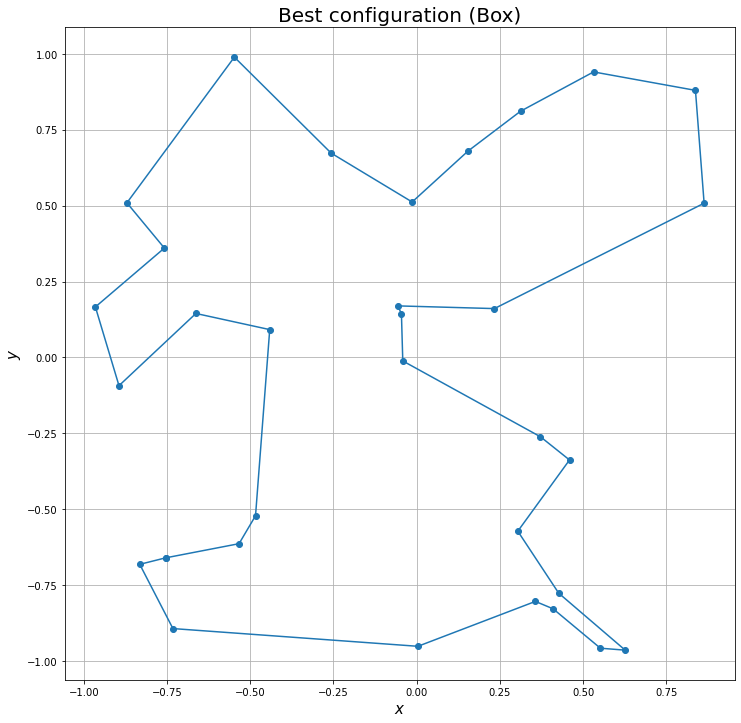

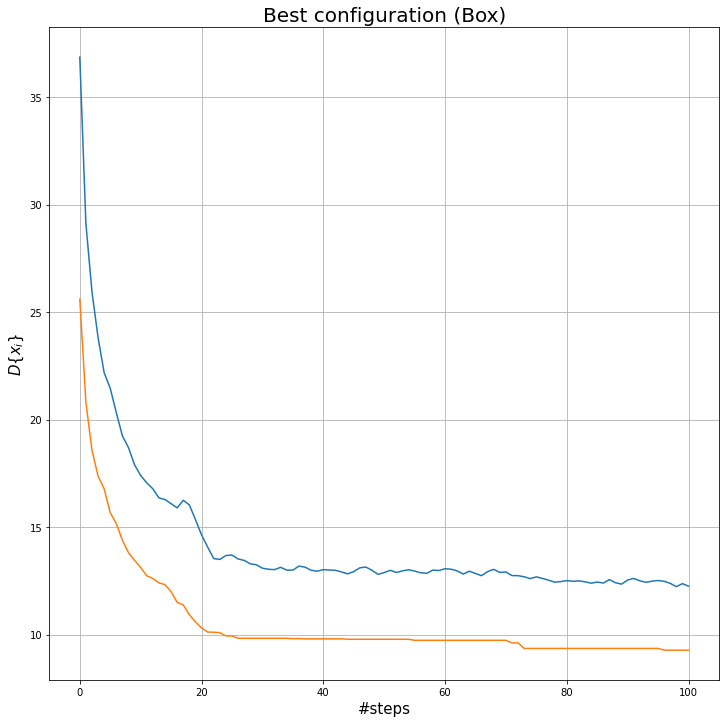

Best distance: 9.27331


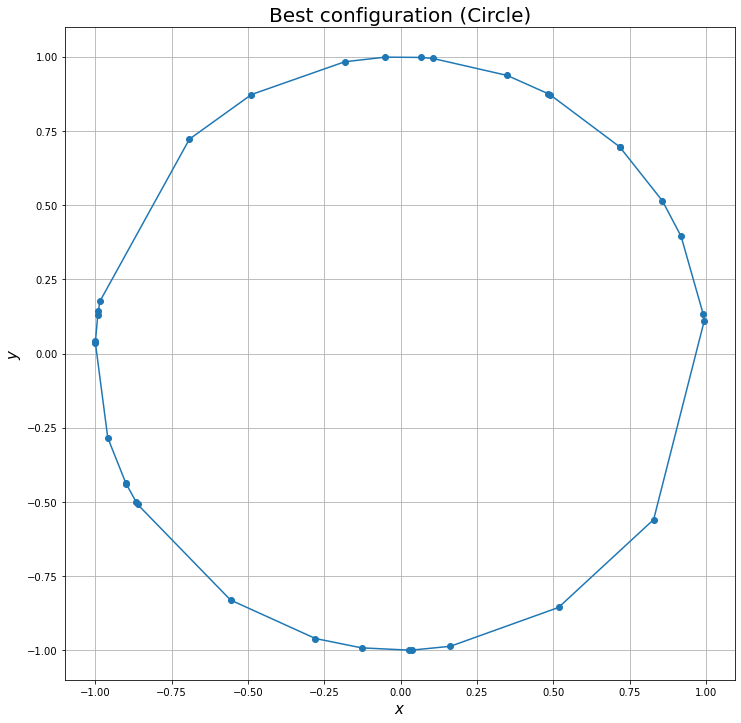

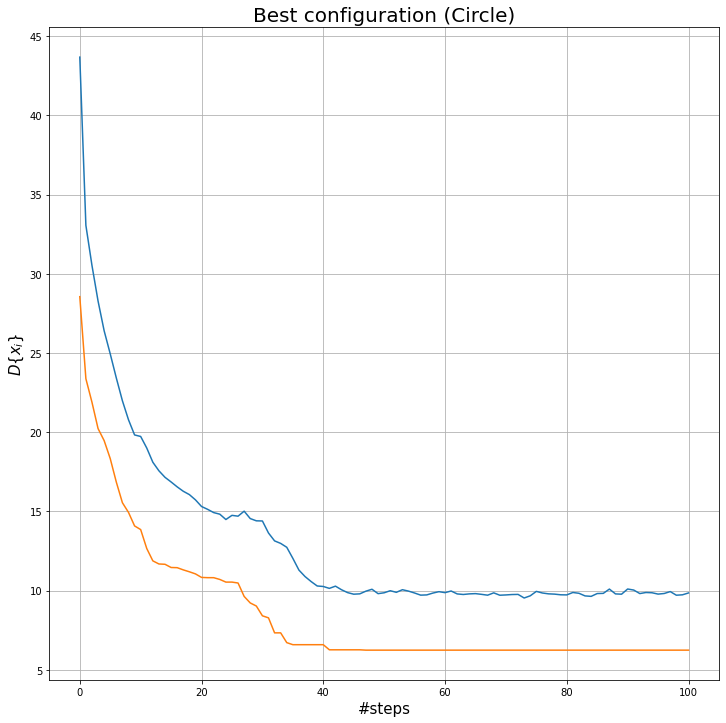

Best distance: 6.2403


In [2]:
def run_simulation(directory, shape):
    subprocess.check_output(["/bin/sh", "-c", 'perl -i -pe "s/#define .*.$/#define '+str(shape)+'/ if $. == 4" '+sourceDirectory+'city.h'])
    subprocess.check_output(["/bin/sh", "-c", "cd "+sourceDirectory+"; make clean"])
    subprocess.check_output(["/bin/sh", "-c", "cd "+sourceDirectory+"; make"])
    subprocess.check_output(["/bin/sh", "-c", "cd "+sourceDirectory+"; ./T_S_P.exe"])

    subprocess.check_output(["/bin/sh", "-c", "cp "+sourceDirectory+"path_average.txt "+directory+"path_average.txt"])
    subprocess.check_output(["/bin/sh", "-c", "cp "+sourceDirectory+"best_configuration.txt "+directory+"best_configuration.txt"])
    subprocess.check_output(["/bin/sh", "-c", "cp "+sourceDirectory+"best_distance.txt "+directory+"best_distance.txt"])

def plot_simulation(directory, dist):
    count = 0
    x = []
    y = []
    with open(directory+'/best_configuration.txt', 'r') as reader:
        for line in reader:
            data = line.split()
            x.append(float(data[0]))
            y.append(float(data[1]))
            count += 1
    plt.figure(figsize=(12, 12))
    plt.title('Best configuration ('+str(dist)+')', fontsize=titleSize)
    plt.plot(x, y, 'o-')
    plt.xlabel('$x$', fontsize=axesLabelSize)
    plt.ylabel('$y$', fontsize=axesLabelSize)
    plt.grid(True)
    plt.show()
    
    path = []
    bestPath = []
    count = 0
    with open(directory+'/path_average.txt', 'r') as reader:
        for line in reader:
            data = line.split()
            path.append(float(data[0]))
            bestPath.append(float(data[1]))
            count += 1
        
    n = np.arange(count)
    plt.figure(figsize=(12, 12))
    plt.title('Best configuration ('+str(dist)+')', fontsize=titleSize)
    plt.plot(n, path, label='Average Distance of the best half of the population')
    plt.plot(n, bestPath, label='Best Distance')
    plt.xlabel('#steps', fontsize=axesLabelSize)
    plt.ylabel('$D\{x_i\}$', fontsize=axesLabelSize)
    plt.grid(True)
    plt.show()

    with open(directory+'/best_distance.txt', 'r') as reader:
        for line in reader:
            bestDistance = float(line)
    print('Best distance:', bestDistance)

directories = [squareDirectory, circleDirectory]
distribution = ['Box', 'Circle']
shapes = ['_BOX_', '_CIRCLE_']

for i in range(len(directories)):
    run_simulation(directories[i], shapes[i])
    plot_simulation(directories[i], distribution[i])

Regarding the cities on the circumference, there are no lines crossing, so the best result according to the genetic algorithm is the true best result (absolute minimum). Additionally, the result is smaller than $\pi$.

Regarding the cities inside the square, there are no lines crossing, so the result is at least good. I have no proof that this is the best result possible with this configuration, though.

Side note: the algorithm converges very quickly (less than $60$ generations).